In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style('darkgrid')

In [6]:
def savefig(filename):
    """Convenience function for saving images."""
    
    plt.savefig(f"{filename}.png", dpi=200, bbox_inches='tight')

In [7]:
df_1980 = pd.read_csv('olympics_1980_subset.csv')
df_1980 = df_1980.drop(columns=['Unnamed: 0'])

In [8]:
df_1980.dtypes

Sex       object
Age        int64
Height     int64
Weight     int64
NOC       object
Year       int64
Season    object
City      object
Sport     object
dtype: object

In [78]:
df_1980.Age.describe()

count    148083.000000
mean         25.231384
std           5.379525
min          12.000000
25%          22.000000
50%          25.000000
75%          28.000000
max          71.000000
Name: Age, dtype: float64

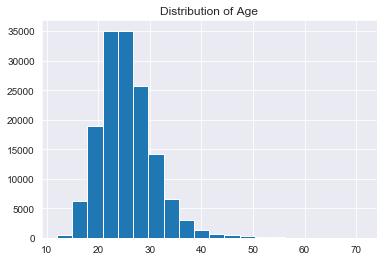

In [79]:
plt.hist(df_1980.Age, bins=20)
plt.title("Distribution of Age")
savefig('age_hist')
plt.show()

In [9]:
df_1980.head()

,Sex,Age,Height,Weight,NOC,Year,Season,City,Sport
0,M,24,180,80,CHN,1992,Summer,Barcelona,Basketball
1,M,23,170,60,CHN,2012,Summer,London,Judo
2,F,21,185,82,NED,1988,Winter,Calgary,Speed Skating
3,F,21,185,82,NED,1988,Winter,Calgary,Speed Skating
4,F,25,185,82,NED,1992,Winter,Albertville,Speed Skating


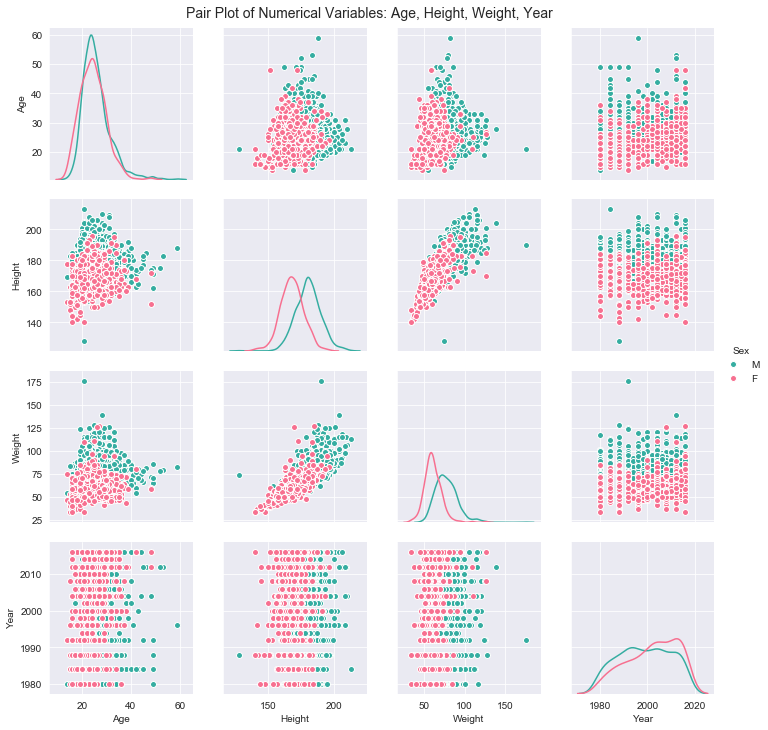

In [52]:
subsample = df_1980.sample(frac=.01, random_state=6)

g = sns.PairGrid(subsample, hue='Sex', palette=sns.husl_palette(2, h=.5))

g = g.map_offdiag(plt.scatter, edgecolor='w')
g = g.map_diag(sns.kdeplot)
plt.suptitle("Pair Plot of Numerical Variables: Age, Height, Weight, Year", x=.48, y=1.01,
            fontsize=14)
g.add_legend()
savefig('num_variables_pairplot')

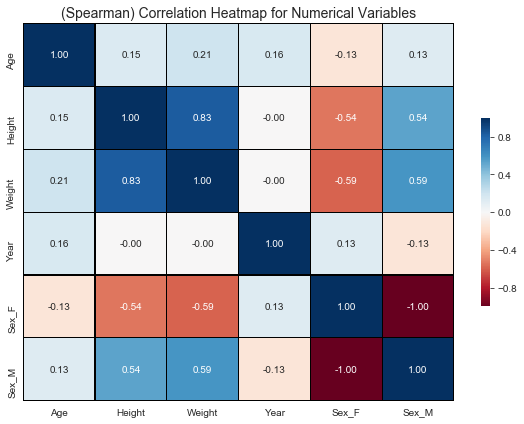

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
corr_mat = pd.get_dummies(df_1980, columns=['Sex']).corr(method='spearman') 

sns.heatmap(corr_mat, annot=True, cmap='RdBu', fmt='.2f', vmin=-1, vmax=1,
           linewidths=.1, linecolor='black', cbar_kws={'shrink':0.5})

plt.title("(Spearman) Correlation Heatmap for Numerical Variables", fontsize=14)
plt.tight_layout()
savefig('corr_heatmap')
plt.show()

In [12]:
def get_value_counts(df, column, top_n=None):
    
    """Convenience function for calling .value_counts()
    on some of our categorical variables, to make drawing
    the plots faster."""
    
    if top_n:
        val_counts = df[column].value_counts()[:top_n]
        
    else:
        val_counts = df[column].value_counts()
        
    return val_counts

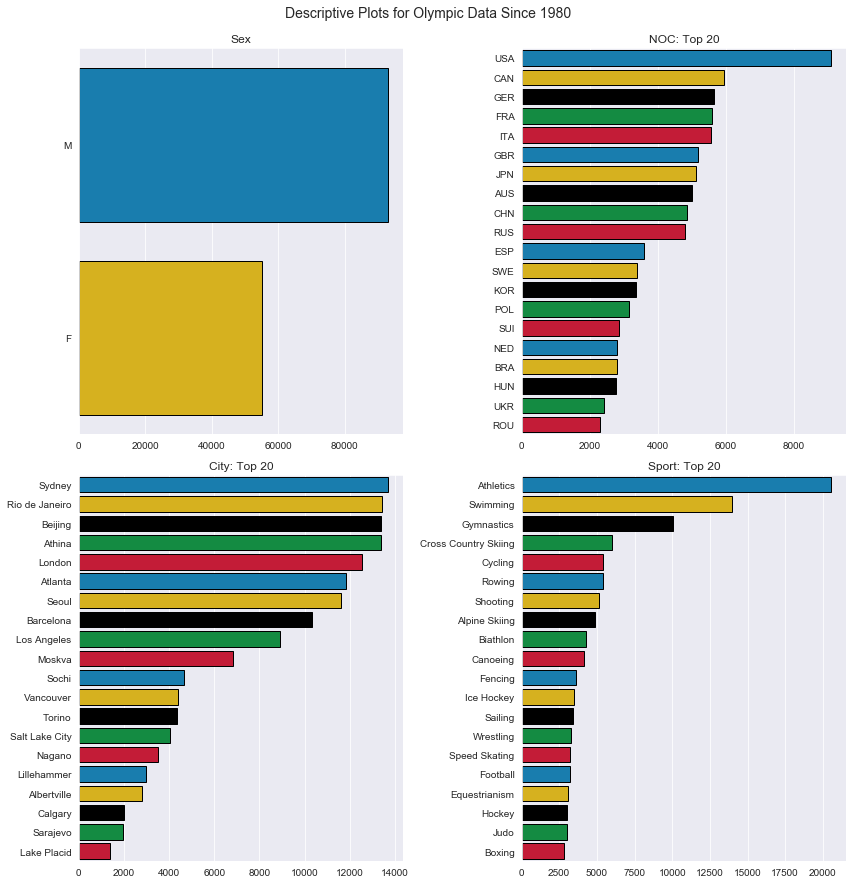

In [13]:
fig, ax = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(12, 12))
ax = ax.flatten()

olympic_colors = ['#0085C7', '#F4C300', '#000000', '#009F3D', '#DF0024']
vars_list = ['Sex', 'NOC', 'City', 'Sport']

for a, variable in zip(ax, vars_list):
    
    data_to_plot = get_value_counts(df_1980, variable, top_n=20)
    
    sns.barplot(data_to_plot.values, data_to_plot.index, ax=a,
               edgecolor='black', palette=olympic_colors)
    
    if variable != 'Sex':
        a.set_title(f'{variable}: Top 20')
    else:
        a.set_title(f'{variable}')
    
plt.suptitle("Descriptive Plots for Olympic Data Since 1980", fontsize=14, y=1.02)
plt.tight_layout()
savefig('categorical_variables')
plt.show()

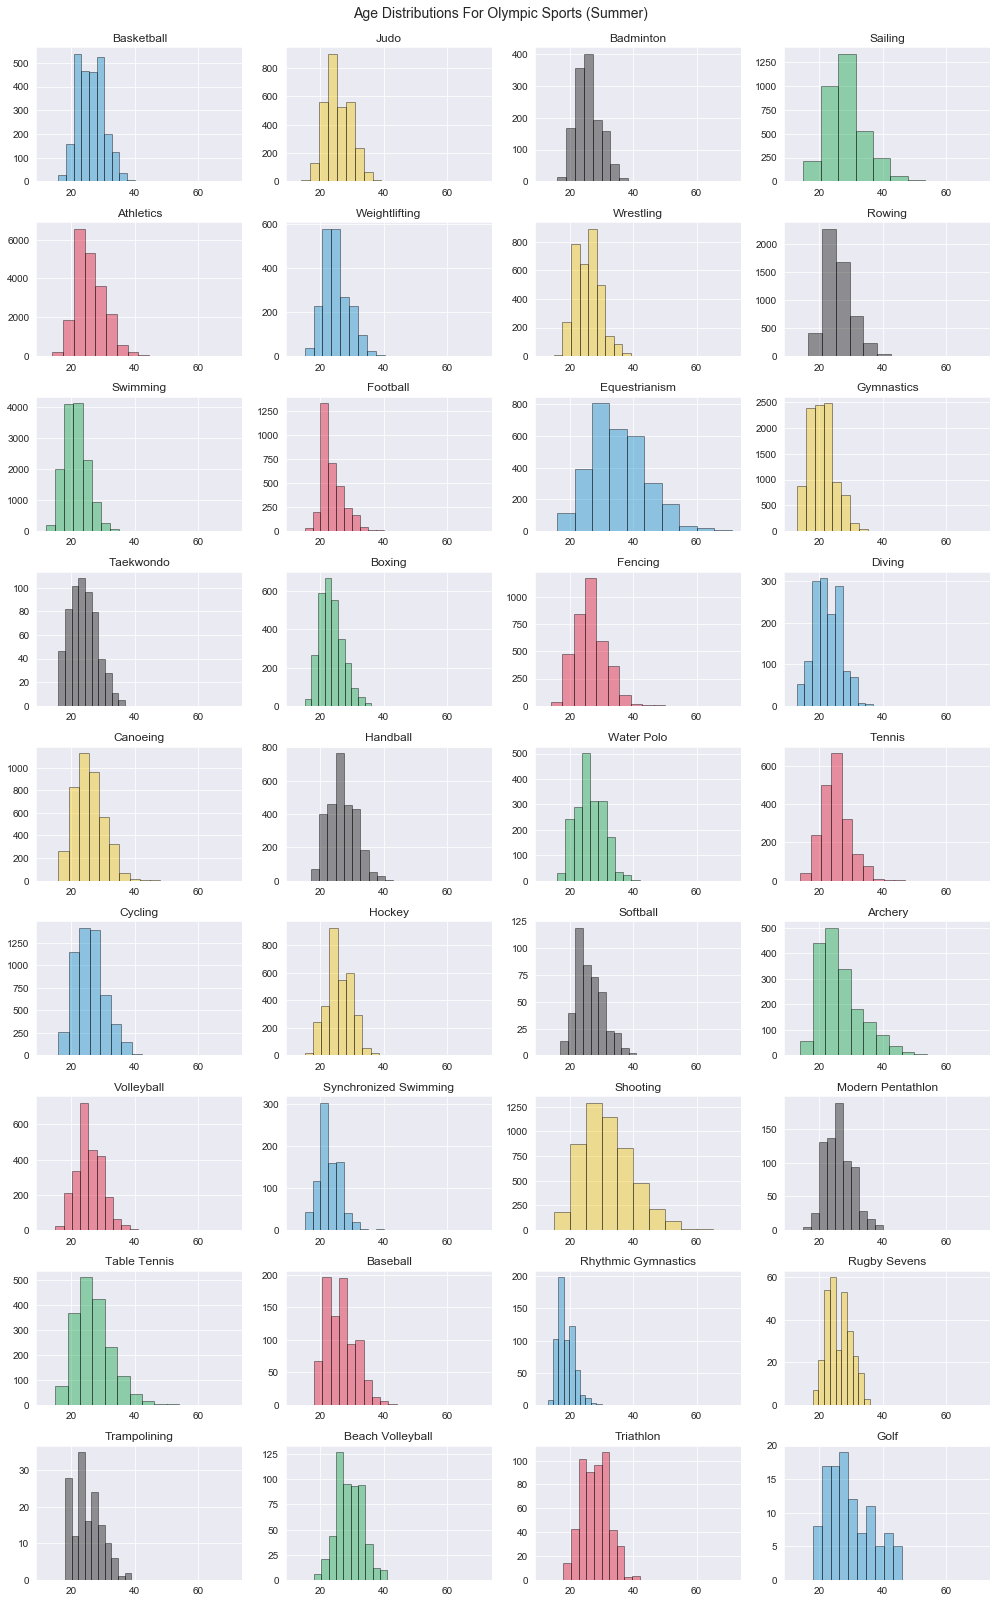

In [14]:
summer_only = df_1980[df_1980['Season'] == 'Summer']
fig, ax = plt.subplots(9, 4, figsize=(14, 22), sharex=True)
ax = ax.flatten()

sports = summer_only['Sport'].unique()
olympic_colors = ['#0085C7', '#F4C300', '#000000', '#009F3D', '#DF0024']
plot_colors = sns.color_palette(olympic_colors) * 11

for a, sport, color in zip(ax, sports, plot_colors):
    sport_subset = summer_only[summer_only['Sport'] == sport]
    sns.distplot(sport_subset['Age'].dropna(), kde=False, ax=a, bins=10,
                 color=color, hist_kws={'edgecolor':'black'})
    a.set_xlabel('')
    a.xaxis.set_tick_params(which='both', labelbottom=True)
    a.set_title(sport)
    
plt.suptitle("Age Distributions For Olympic Sports (Summer)", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

In [15]:
# Import the items we'll need from the sklearn library
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [16]:
# Check the percentage of null values in each column
df_1980.isnull().sum() / len(df_1980)

Sex       0.0
Age       0.0
Height    0.0
Weight    0.0
NOC       0.0
Year      0.0
Season    0.0
City      0.0
Sport     0.0
dtype: float64

In [23]:
rs = 6 # set random seed

# Separate the y-values (age) from the rest of the variables
y = df_1980['Age']

# get_dummies turns the categorical variables into dummy variables
X = pd.get_dummies(df_1980.drop(columns=['Age']))

# Separate data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rs, 
                                                    shuffle=True, train_size=.9)

# First we'll fit the model with the parameters that are typically used
# for random forest regression, as laid out by ESL
rf_params = {'random_state':rs,
             'oob_score':True, # Performs something similar to cross-validation
             'n_estimators':200,
             'max_features':'sqrt'}

# Unpack the dictionary of parameters as arguments to the Regressor object
# (that's what the **s are doing)
rf = RandomForestRegressor(**rf_params)

In [24]:
import math

# Fit the random forest to the data
rf.fit(X_train, y_train)

# Get the model's predictions for the test data
y_pred = rf.predict(X_test)

# Assess model performance: calculate mean squared error, then take the square root
# (this gives us the error in our original units; since this is age, it's years)
mse = mean_squared_error(y_test, y_pred)
math.sqrt(mse)

3.523037325963258

In [25]:
def prediction_plot(y_test, y_pred, model_name):
    
    """Convenience function for plotting predictions
    against true values."""
    
    sns.regplot(y_test, y_pred, scatter_kws={'alpha':.5}, line_kws={'color':'red'})
    plt.xlabel('True Values for Age')
    plt.ylabel('Predicted Values for Age')
    plt.title(f'{model_name} Predicted Values vs. True Values for Age')
    savefig('prediction_plot')
    plt.show()

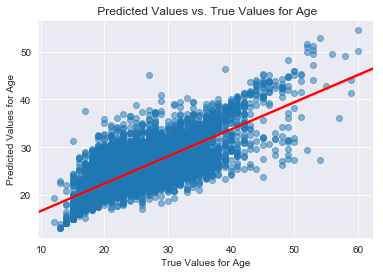

In [26]:
prediction_plot(y_test, y_pred, '')

RMSE is measured in the original units - so in years, the model is off on average by 3.52 years. The true y-values are plotted against the predicted y-values for Age above. 

Future directions would include performing a randomized search to locate the best-performing hyperparameters for the model.

In [47]:
# Extract the variable importances from the rf object
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

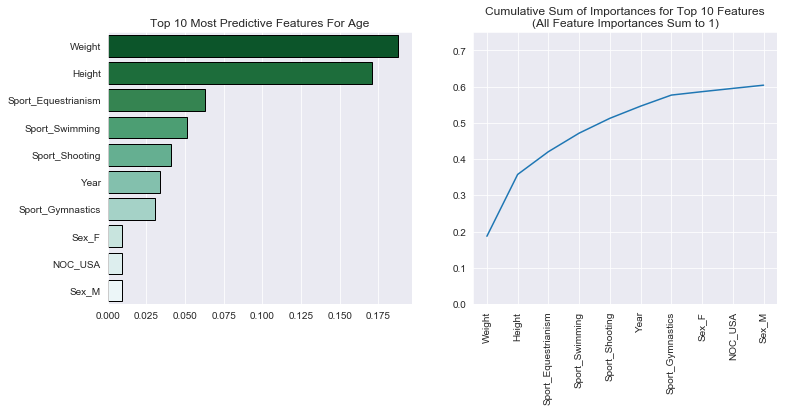

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(y=importances.index[:10], x=importances.values[:10], 
            palette='BuGn_r', edgecolor='black', ax=ax[0])

ax[1].plot(np.cumsum(importances[:10]))

ax[0].set_title("Top 10 Most Predictive Features For Age")
ax[1].set_title("Cumulative Sum of Importances for Top 10 Features" +
                "\n(All Feature Importances Sum to 1)")
ax[1].set_xticklabels(importances.index[:10], rotation=90)
ax[1].set_ylim(0, .75)

savefig('most_predictive_features')
plt.show()

In [49]:
# Get the variables w/ strongest positive and negative correlations with Age, for comparison
strongest_pos = X.corrwith(y, method='spearman').sort_values(ascending=False)[:8] 
strongest_neg = X.corrwith(y, method='spearman')\
                    .sort_values(ascending=False)[-5:].sort_values()

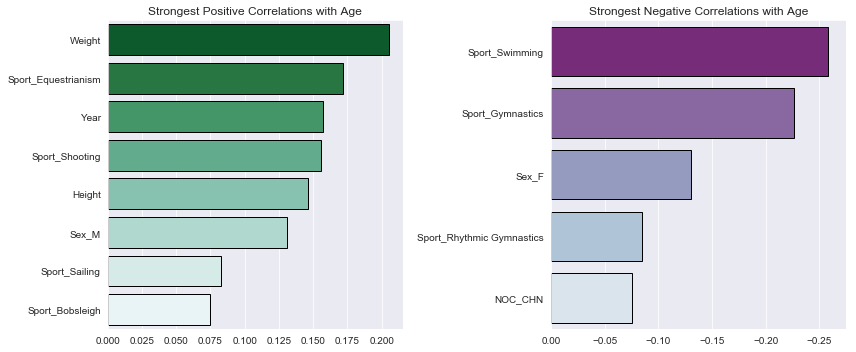

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharex=False, sharey=False)
ax = ax.flatten()

calcs_dict = {'Positive':strongest_pos, 'Negative':strongest_neg}
palettes = ['BuGn_r', 'BuPu_r']

for calc, sign, a, palette in zip(calcs_dict.values(), calcs_dict.keys(), ax, palettes):
    sns.barplot(x=calc.values, y=calc.index, 
                edgecolor='black', palette=palette, 
                ax=a).set_title(f"Strongest {sign} Correlations with Age")

ax[1].set_xlim(0, -.275)
plt.tight_layout()
savefig('strongest_correlations')

# We see that many of the features that are most correlated show up
# in the "most predictive" graph as well.

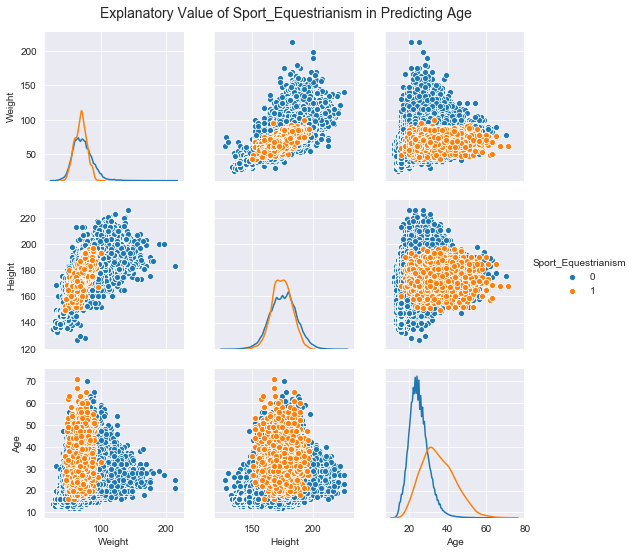

In [51]:
X['Age'] = y

vars_to_viz = ['Weight', 'Height', 'Age']

g = sns.PairGrid(X, x_vars=vars_to_viz, y_vars=vars_to_viz, hue='Sport_Equestrianism')
g = g.map_offdiag(sns.scatterplot)
g = g.map_diag(sns.kdeplot)
g.add_legend()

plt.suptitle("Explanatory Value of Sport_Equestrianism in Predicting Age", x=.46, y=1.02, 
             fontsize=14)
savefig('equestrianism_explanatory_value')
plt.show()